In [1]:
# pip install git+https://github.com/ourownstory/neural_prophet.git

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
import pandas as pd
import plotly.express as px
import numpy as np
import plotly.graph_objects as go
import matplotlib.pylab as plt
import seaborn as sns
import plotly.io as pio
import itertools

from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from neuralprophet import NeuralProphet, set_random_seed


In [3]:
set_random_seed(0)
np.random.seed(1)
pio.renderers.default='notebook'

In [4]:
def missing_values(df):
    missing_count = df.isnull().sum()
    percent_missing = missing_count * 100 / len(df)
    values_available = len(df) - missing_count

    missing_value_df = pd.DataFrame({
        'column_name': df.columns,
        "non_misisng_count": values_available,
        'missing_count': missing_count,
        
        'percent_missing': percent_missing
    })
    missing_value_df.sort_values('percent_missing', inplace=True)

    return missing_value_df

In [5]:
def handle_outliers(ar):
    upper_limit = ar.quantile(0.95)
    lower_limit = ar.quantile(0.05)
    if lower_limit < 1:
        lower_limit = 1
        
    ar[ar > upper_limit] = upper_limit
    ar[ar < lower_limit] = lower_limit

    
def kpss_test(series, strItem, **kw):    
    try:
        statistic, p_value, n_lags, critical_values = kpss(series, regression='c', **kw)
        return { 'KPSS Statistic' : statistic, 'p_value' : p_value, 'Critical value': critical_values['5%'] }
    except:
        return { 'KPSS Statistic' : 0, 'p_value' : 0, 'Critical value': 0 }
        pass
        

In [6]:
def downcast(df):

    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()

    for i,t in enumerate(types):

        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)

        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)

        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')

    return df 

In [7]:
#чтение файлов
sales = pd.read_csv("sales_train_evaluation.csv")
# prices = pd.read_csv("D:/Research Proposal Raja Sekhar Somepalli/m5-forecasting-accuracy/sell_prices.csv")
calendar = pd.read_csv("calendar.csv")

In [8]:
#sales = sales.loc[sales.id.isin(lst_selItems)]
sales = downcast(sales)
calendar = downcast(calendar)
# prices = downcast(prices)

In [9]:
# праздники
lst_events = calendar.event_name_1.dropna().unique().to_list()
events_df = pd.DataFrame(columns = ['event', 'ds'])
for strEvent in lst_events:
    events_df = events_df.append(pd.DataFrame({
        'event': strEvent,
        'ds': calendar.loc[(calendar[['event_name_1', 'event_name_2']] == strEvent).any(axis=1)].date.unique()
    }))
    
for strEvent in ['snap_CA','snap_TX','snap_WI']:
     events_df = events_df.append(pd.DataFrame({
        'event': strEvent,
        'ds': calendar.loc[(calendar[strEvent] > 0)].date.unique()
    }))

lst_events.extend(['snap_CA','snap_TX','snap_WI'])

events_df

event         ds
0    SuperBowl 2011-02-06
1    SuperBowl 2012-02-05
2    SuperBowl 2013-02-03
3    SuperBowl 2014-02-02
4    SuperBowl 2015-02-01
..         ...        ...
645    snap_WI 2016-06-09
646    snap_WI 2016-06-11
647    snap_WI 2016-06-12
648    snap_WI 2016-06-14
649    snap_WI 2016-06-15

[2117 rows x 2 columns]

In [10]:
cols_id = ['id', 'item_id',  'dept_id', 'cat_id', 'store_id', 'state_id']
df_sales=pd.melt(sales, id_vars=cols_id, var_name='d', value_name='sales')
df_sales= pd.merge(df_sales, calendar, on='d', how='left')
df_plot = df_sales
df_sales = df_sales[['id','date','sales']]
df_sales = downcast(df_sales)
df_sales

id       date  sales
0         HOBBIES_1_001_CA_1_evaluation 2011-01-29      0
1         HOBBIES_1_002_CA_1_evaluation 2011-01-29      0
2         HOBBIES_1_003_CA_1_evaluation 2011-01-29      0
3         HOBBIES_1_004_CA_1_evaluation 2011-01-29      0
4         HOBBIES_1_005_CA_1_evaluation 2011-01-29      0
...                                 ...        ...    ...
59181085    FOODS_3_823_WI_3_evaluation 2016-05-22      1
59181086    FOODS_3_824_WI_3_evaluation 2016-05-22      0
59181087    FOODS_3_825_WI_3_evaluation 2016-05-22      2
59181088    FOODS_3_826_WI_3_evaluation 2016-05-22      0
59181089    FOODS_3_827_WI_3_evaluation 2016-05-22      1

[59181090 rows x 3 columns]

In [12]:
cols_id = ['id', 'item_id',  'dept_id', 'store_id','cat_id', 'state_id']

In [11]:
df_cat=pd.melt(sales, id_vars=cols_id, var_name='d', value_name='sales')
del sales
df_cat= pd.merge(df_cat, calendar, on='d', how='left')
df_cat = df_cat[['cat_id','date','sales']]
df_cat = downcast(df_cat)
df_cat

cat_id       date  sales
0         HOBBIES 2011-01-29      0
1         HOBBIES 2011-01-29      0
2         HOBBIES 2011-01-29      0
3         HOBBIES 2011-01-29      0
4         HOBBIES 2011-01-29      0
...           ...        ...    ...
59181085    FOODS 2016-05-22      1
59181086    FOODS 2016-05-22      0
59181087    FOODS 2016-05-22      2
59181088    FOODS 2016-05-22      0
59181089    FOODS 2016-05-22      1

[59181090 rows x 3 columns]

In [12]:
events_df.event.value_counts()

snap_WI                650
snap_TX                650
snap_CA                650
Mother's day             6
Easter                   6
ValentinesDay            6
Father's day             6
NBAFinalsEnd             6
NBAFinalsStart           6
MemorialDay              6
SuperBowl                6
Cinco De Mayo            6
Pesach End               6
PresidentsDay            6
LentStart                6
LentWeek2                6
Ramadan starts           6
StPatricksDay            6
Purim End                6
OrthodoxEaster           6
Eid al-Fitr              5
LaborDay                 5
ColumbusDay              5
Halloween                5
EidAlAdha                5
Thanksgiving             5
Christmas                5
Chanukah End             5
NewYear                  5
OrthodoxChristmas        5
MartinLutherKingDay      5
IndependenceDay          5
VeteransDay              5
Name: event, dtype: int64

In [ ]:
#del sales, calendar

In [ ]:
df_cat.cat_id.value_counts()

In [14]:
lst_selItems = ['HOBBIES', 'HOUSEHOLD', 'FOODS']


In [15]:
fig = go.Figure()
for item in lst_selItems:
    samp = df_cat.loc[(df_cat.cat_id == item)].sort_values(by=['date'], ascending=True)
    fig.add_trace(go.Scatter(x=samp.date, y=samp.sales, name = item))

fig.update_layout(xaxis_title="Time", yaxis_title="Sales",title="",title_x=0.5)
fig.show()

In [ ]:
fig = go.Figure()

samp = df_sales.sort_values(by=['date'], ascending=True)
fig.add_trace(go.Scatter(x=samp.date, y=samp.sales, name = item))

fig.update_layout(xaxis_title="Time", yaxis_title="Sales",title="",title_x=0.5)
fig.show()

KeyError: 0

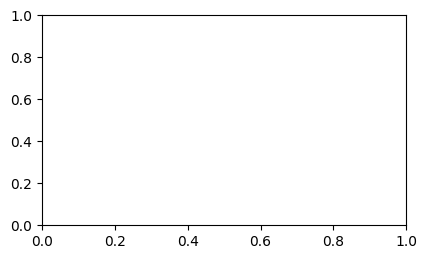

In [16]:
plt.figure(figsize = (16, 6))
meanprops = dict(linestyle='-', linewidth=4, color='red')
int_figno = 1

for strItem in lst_selItems:
    df_filt = df_sales.loc[df_sales.id == strItem].sales
    plt.subplot(2,3,int_figno)
    sns.boxplot(df_filt, meanline=True, showmeans = True, meanprops = meanprops)
    plt.title(strItem.replace("_evaluation",''))
    int_figno += 1
    
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace= 0.3, wspace= 0.3)
plt.show()
    


In [17]:
lst_selItems = ['FOODS_3_252_TX_2_evaluation','FOODS_3_555_CA_1_evaluation','FOODS_3_714_TX_3_evaluation',
 'FOODS_3_586_WI_1_evaluation','FOODS_3_252_TX_1_evaluation','FOODS_3_714_TX_2_evaluation']

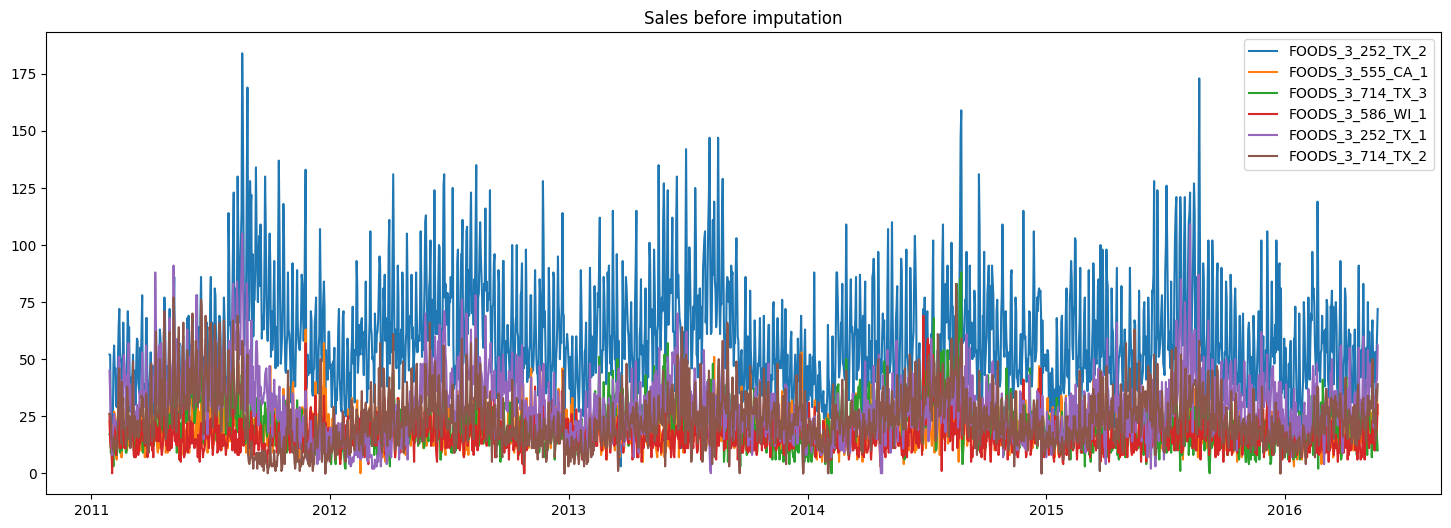

In [18]:
plt.figure(figsize=(18,6))
for strItem in lst_selItems:
    df_items = df_sales.loc[df_sales.id == strItem]
    df_items=df_items[['date','sales']]
    df_items = df_items.set_index('date')
    plt.plot(df_items, label=strItem.replace("_evaluation",''))
    
plt.legend(loc='best')
plt.title('Sales before imputation')
plt.show()

In [19]:
for strItem in lst_selItems:
    df_filt = df_sales.loc[df_sales.id == strItem]
    df_plot_filt = df_plot.loc[df_plot.id == strItem]
    handle_outliers(df_filt.sales)
    handle_outliers(df_plot_filt.sales)
    df_sales = df_sales.loc[df_sales.id != strItem]
    df_sales = df_sales.append(df_filt)
    df_plot = df_plot.loc[df_plot.id != strItem]
    df_plot = df_plot.append(df_plot_filt)

KeyError: 0

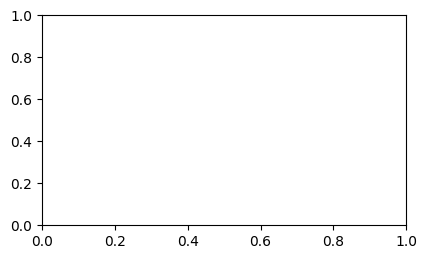

In [20]:
plt.figure(figsize = (16, 6))
meanprops = dict(linestyle='-', linewidth=4, color='red')
int_figno = 1

for strItem in lst_selItems:
    df_filt = df_sales.loc[df_sales.id == strItem].sales
    plt.subplot(2,3,int_figno)
    sns.boxplot(df_filt, meanline=True, showmeans = True, meanprops = meanprops)
    plt.title(strItem.replace("_evaluation",''))
    int_figno += 1
    
    
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace= 0.3, wspace= 0.3)
plt.show()
    

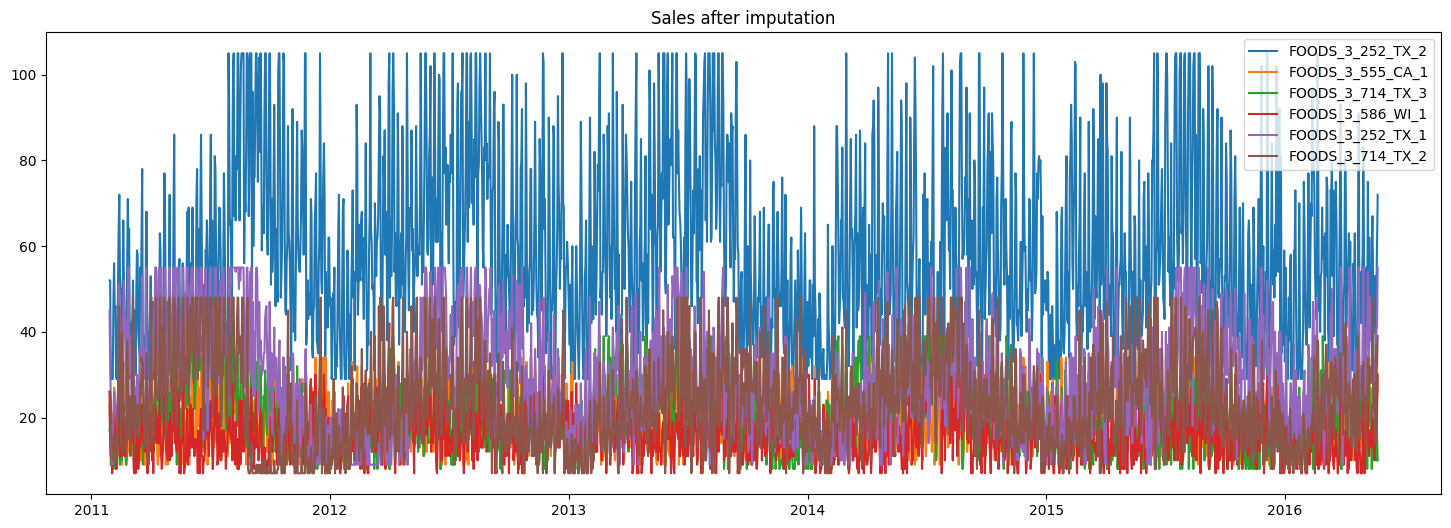

In [21]:
plt.figure(figsize=(18,6))
for strItem in lst_selItems:
    df_items = df_sales.loc[df_sales.id == strItem]
    df_items=df_items[['date','sales']]
    df_items = df_items.set_index('date')
    plt.plot(df_items, label=strItem.replace("_evaluation",''))
    
plt.legend(loc='best')
plt.title('Sales after imputation')
plt.show()

In [22]:
def univariatePlot(data,col,width=20,height=10,rotation=90):
                
        fig, ax = plt.subplots(figsize=(width,height))
        sns.countplot(data = data, y= col,order=data[col].value_counts().index)
        plt.xticks(rotation=rotation,fontsize=12)
        plt.yticks(fontsize=12)
        plt.xlabel(col,fontsize=14)
        plt.ylabel('count',fontsize=12)
        plt.tight_layout()
        for p in ax.patches:
                if float(p.get_height()) > 0:
                    height = p.get_height()
                    ax.annotate('{:1.2f}%'.format((height*100)/float(len(data))), (p.get_x()+0.05, height+50),weight='bold',fontsize=12)  
                else:
                    height = .00000001
                    ax.annotate('{:1.2f}%'.format((height*100)/float(len(data))), (p.get_x()+0.05, height+20),weight='bold',fontsize=12)  
        
plt.show()

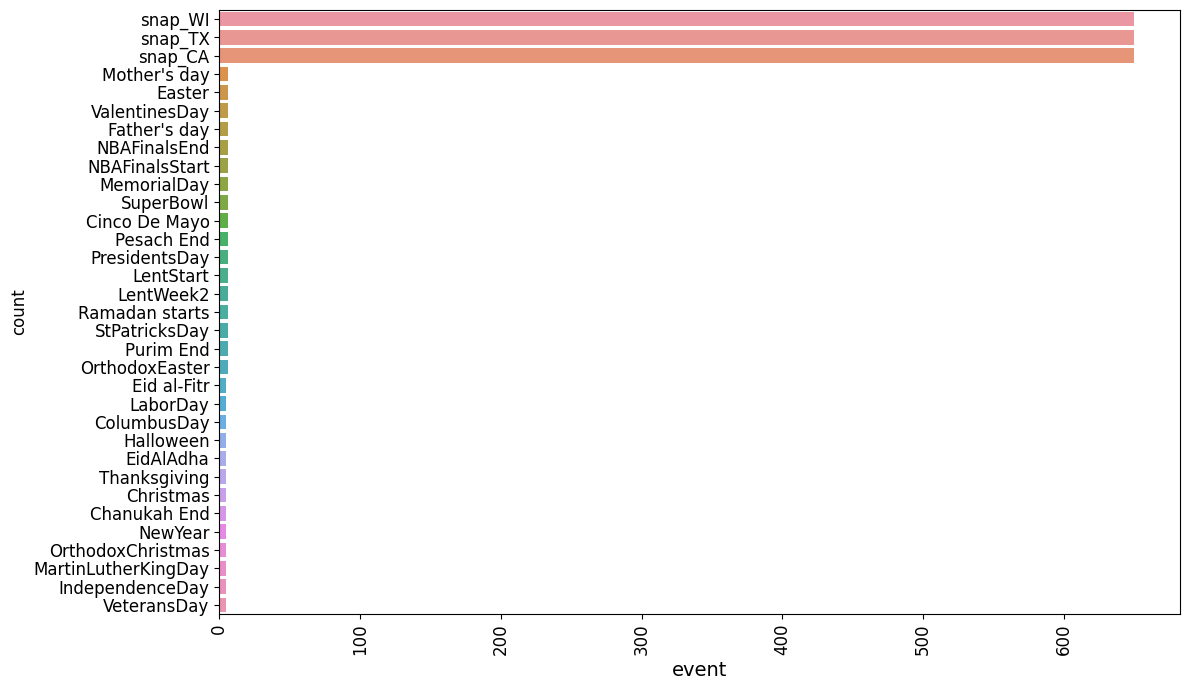

In [23]:
univariatePlot(events_df,'event',12,7)

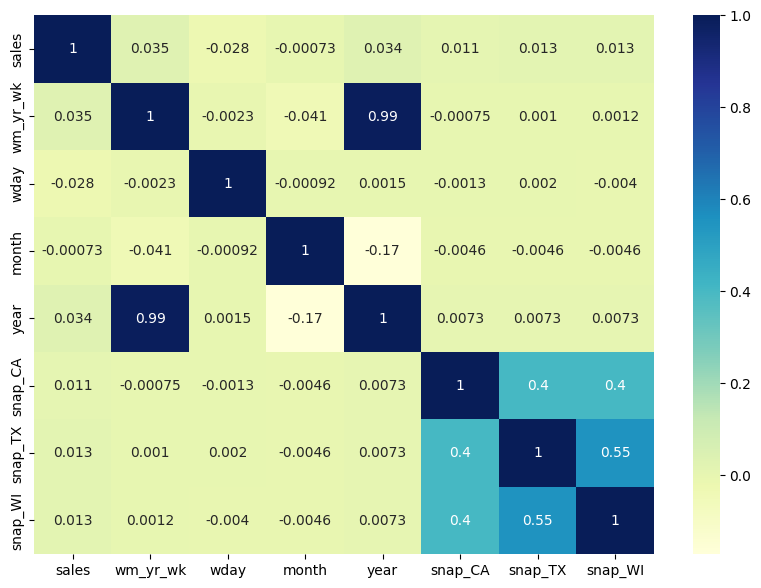

In [24]:

plt.figure(figsize = (10, 7))
sns.heatmap(df_plot.corr(), annot = True, cmap="YlGnBu")
plt.show()

In [25]:
sales = pd.DataFrame(df_plot.groupby(['year', 'month','id'])['sales'].sum())
sales.reset_index(inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(x = 'year', y = 'sales', hue = 'id', data = sales)
plt.show()

ValueError: Image size of 1014x642979 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1200x600 with 1 Axes>

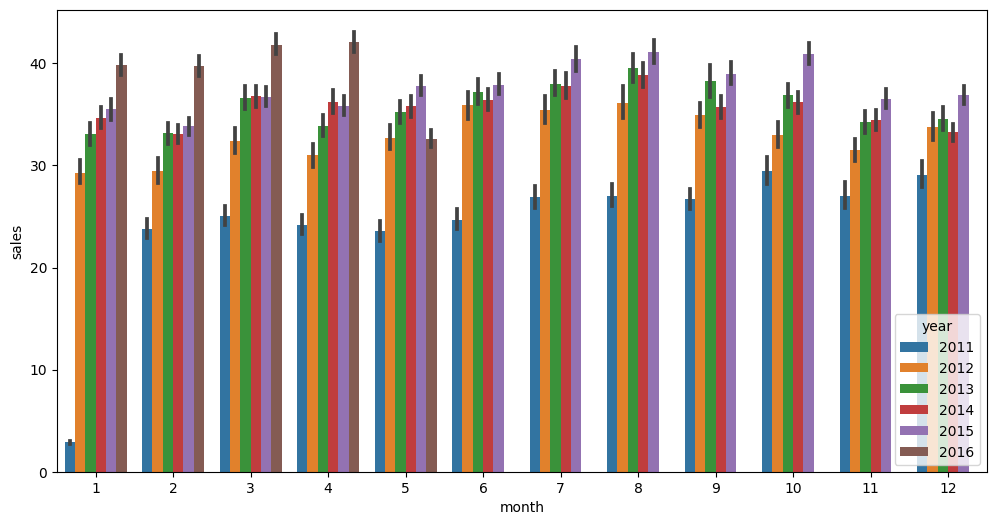

In [26]:
plt.figure(figsize=(12, 6))
sns.barplot(x = 'month', y = 'sales', hue = 'year', data = sales)
plt.show()

<AxesSubplot: xlabel='month'>

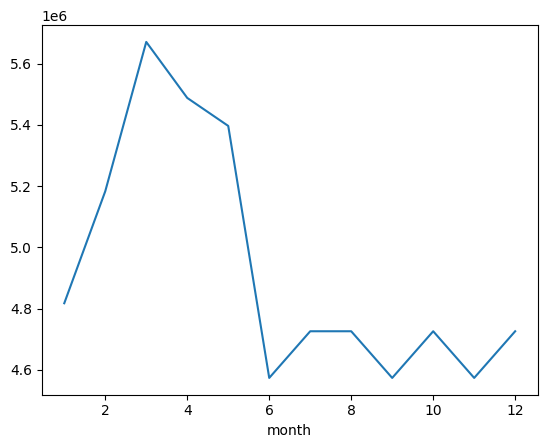

In [27]:
cntmonth = df_plot.groupby('month').count()['sales']
cntmonth.plot(kind='line')

<AxesSubplot: xlabel='wday'>

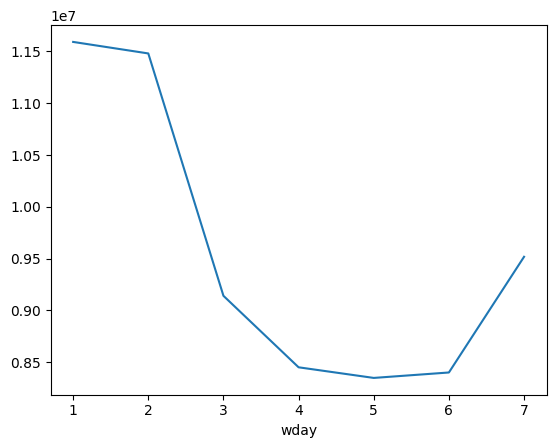

In [28]:
df_plot.groupby('wday').sum()['sales'].plot(kind='line')

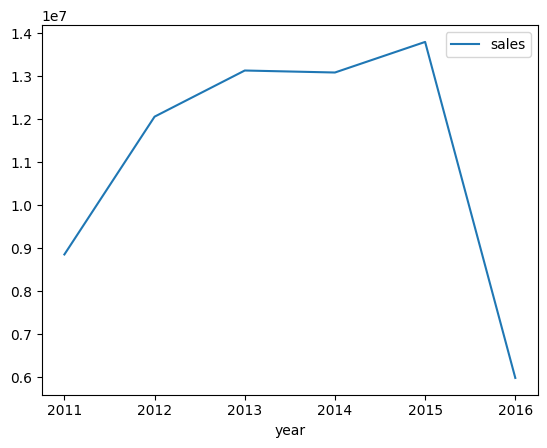

In [29]:
sales=df_plot.groupby(['year'],as_index=False,sort=False).agg(sales=('sales',np.sum))
sales.plot(x='year',y='sales')
plt.show()

In [30]:
kpss_values = pd.DataFrame()
lst_stat_KPSS = []
for strItem in lst_selItems:
    try:
        result = kpss_test(df_sales.loc[df_sales.id == strItem].sales, strItem)
        if result['p_value'] > 0.05:
            kpss_values = kpss_values.append(pd.DataFrame({'Item': [strItem],
                                            'KPSS Statistic': [result['KPSS Statistic']],
                                            'Critical Values @0.05': result['Critical value'],
                                            'P Value' : [result['p_value']],
                                            'total_sales' : [df_sales.loc[df_sales.id == strItem].sales.sum()]
                                           }))
            lst_stat_KPSS.append(strItem)
    except:
        pass
    
kpss_values  

WARNING - (py.warnings._showwarnmsg) - C:\Users\apugacheva\Anaconda3\envs\m5\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.



WARNING - (py.warnings._showwarnmsg) - C:\Users\apugacheva\Anaconda3\envs\m5\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.



WARNING - (py.warnings._showwarnmsg) - C:\Users\apugacheva\Anaconda3\envs\m5\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.



WARNING - (py.warnings._showwarnmsg) - C:\Users\apugacheva\Anaconda3\envs\m5\lib\site-packages\stats

Item  KPSS Statistic  Critical Values @0.05  \
0  FOODS_3_252_TX_2_evaluation        0.414138                  0.463   
0  FOODS_3_555_CA_1_evaluation        0.318034                  0.463   
0  FOODS_3_714_TX_3_evaluation        0.241689                  0.463   
0  FOODS_3_586_WI_1_evaluation        0.276754                  0.463   
0  FOODS_3_252_TX_1_evaluation        0.354350                  0.463   
0  FOODS_3_714_TX_2_evaluation        0.131309                  0.463   

    P Value  total_sales  
0  0.071061       114687  
0  0.100000        38182  
0  0.100000        40779  
0  0.100000        32081  
0  0.096832        56532  
0  0.100000        45690

In [31]:
adf_values = pd.DataFrame()
lst_adf_Stat = []
for strItem in lst_selItems:
    adf_test = adfuller(df_sales.loc[df_sales.id == strItem].sales)
    if adf_test[1] <= 0.5:
        adf_values = adf_values.append(pd.DataFrame({'Item': [strItem],
                                        'ADF Statistic': [adf_test[0]],
                                        'Critical Values @0.05': [adf_test[4]['5%']],
                                        'P Value' : [adf_test[1]],
                                        'total_sales' : [df_sales.loc[df_sales.id == strItem].sales.sum()]

                                       }))
        lst_adf_Stat.append(strItem)
adf_values  

Item  ADF Statistic  Critical Values @0.05  \
0  FOODS_3_252_TX_2_evaluation      -4.157369              -2.863051   
0  FOODS_3_555_CA_1_evaluation      -6.281969              -2.863051   
0  FOODS_3_714_TX_3_evaluation      -3.184919              -2.863051   
0  FOODS_3_586_WI_1_evaluation      -5.432891              -2.863049   
0  FOODS_3_252_TX_1_evaluation      -3.248840              -2.863051   
0  FOODS_3_714_TX_2_evaluation      -3.885015              -2.863051   

        P Value  total_sales  
0  7.773624e-04       114687  
0  3.777219e-08        38182  
0  2.087437e-02        40779  
0  2.888060e-06        32081  
0  1.732608e-02        56532  
0  2.147940e-03        45690

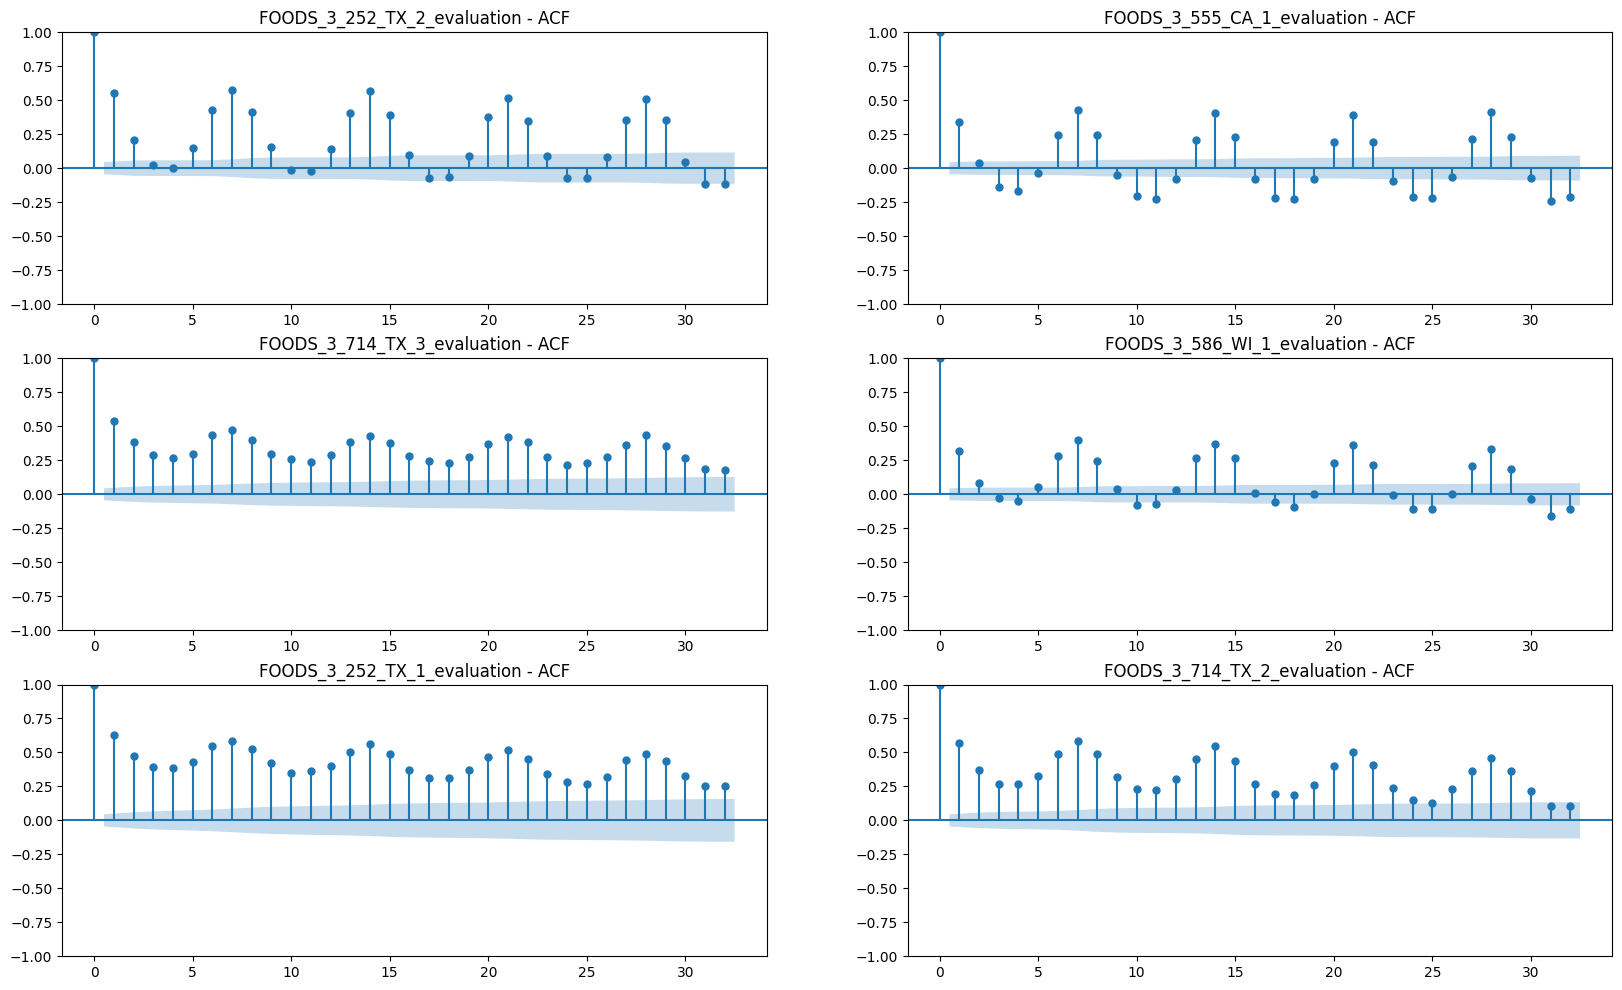

In [32]:
plt.figure(figsize=(20,12))
int_figno = 1
for strItem in lst_selItems:
    df_filt = df_sales.loc[df_sales.id == strItem].sales
    plt.subplot(3,2,int_figno)
    plot_acf(df_filt, ax=plt.gca(), lags = 32)
    plt.title(strItem + ' - ACF')
    int_figno += 1

plt.show()

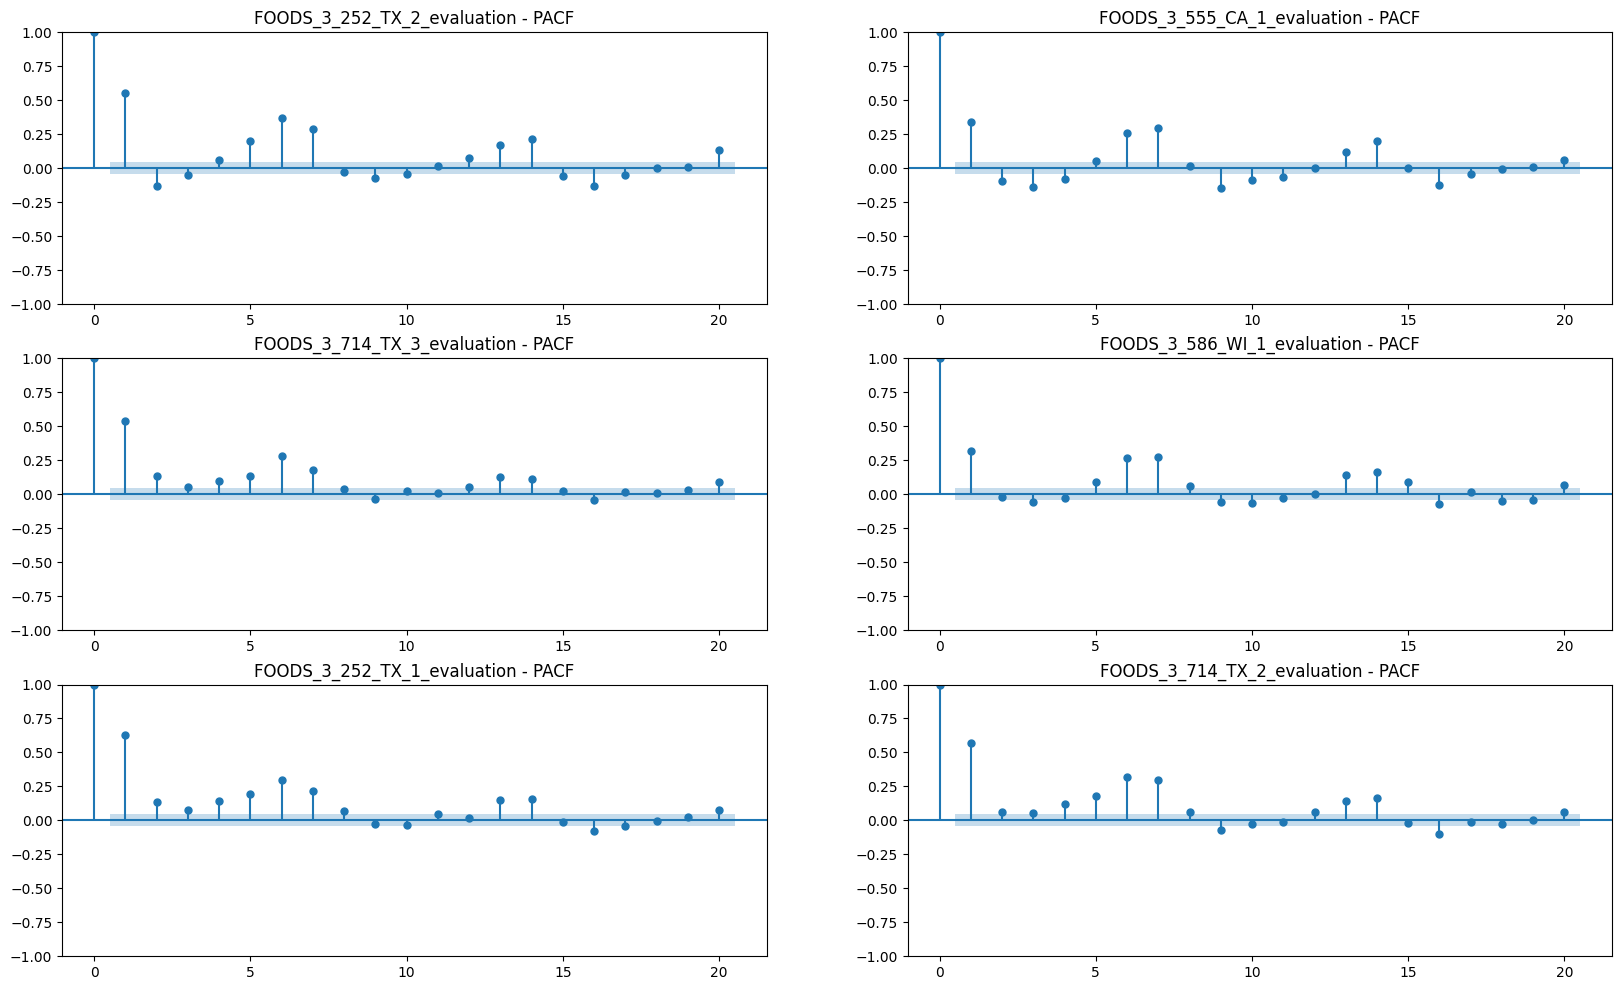

In [33]:
plt.figure(figsize=(20,12))
int_figno = 1
for strItem in lst_selItems:
    df_filt = df_sales.loc[df_sales.id == strItem].sales
    plt.subplot(3,2,int_figno)
    plot_pacf(df_filt, ax=plt.gca(), lags = 20)
    plt.title(strItem + ' - PACF')
    int_figno += 1

plt.show()

In [34]:
fig = go.Figure()
for item in lst_selItems:
    samp = df_sales.loc[(df_sales.id == item)].sort_values(by=['date'], ascending=True)
    fig.add_trace(go.Scatter(x=samp.date, y=samp.sales, name = item))

fig.update_layout(xaxis_title="Time", yaxis_title="Sales",title="",title_x=0.5)
fig.show()

In [35]:
def get_Product_data(strItem, strState):
    df_item = df_sales.loc[df_sales.id == strItem][['date','sales']]
    df_item.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)
    
    lst_state_events = lst_events.copy()
    if strState == 'CA':
        lst_state_events.remove('snap_TX')
        lst_state_events.remove('snap_WI')
    elif strState == 'TX':
        lst_state_events.remove('snap_CA')
        lst_state_events.remove('snap_WI')
    else:
        lst_state_events.remove('snap_CA')
        lst_state_events.remove('snap_TX')
        
    df_state_events = events_df.loc[events_df.event.isin(lst_state_events)]
    return df_item, df_state_events, lst_state_events
    

### FOODS_3_252_TX_2_evaluation

In [39]:
df_item1 = df_sales.loc[['date','sales']]
df_item1.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)

df_item1, df_TX_events, lst_TX_events = get_Product_data('FOODS_3_252_TX_2_evaluation','TX')

# lst_TX_events = lst_events.copy()
# lst_TX_events.remove('snap_CA')
# lst_TX_events.remove('snap_WI')
# df_TX_events = events_df.loc[events_df.event.isin(lst_TX_events)]

KeyError: "None of [Index(['date', 'sales'], dtype='object')] are in the [index]"

In [37]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_item1.ds, y=df_item1.y, name = 'FOODS_3_252_TX_2_evaluation'))
fig.update_layout(xaxis_title="Time", yaxis_title="Sales",title="",title_x=0.5)
fig.show()

NameError: name 'df_item1' is not defined

In [ ]:
m = NeuralProphet(yearly_seasonality=False,
    weekly_seasonality= False,
    daily_seasonality=False,)
df = df_item1
df_train, df_test = m.split_df(df=df, freq="D", valid_p=0.3 )
metrics = m.fit(df=df_train, freq="D" , validation_df=df_test)
metrics.tail(1)

In [ ]:
forecast = m.predict(df_train)
fig = m.plot(forecast,figsize=(12, 4))

In [ ]:
forecast = m.predict(df_test)
# m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast,figsize=(12, 4))

In [ ]:
mape = mean_absolute_percentage_error(forecast.y,forecast.yhat1).round(2)
mape

In [ ]:
fig_param = m.plot_parameters(weekly_start=4)

In [ ]:
m = NeuralProphet(yearly_seasonality=False,
    weekly_seasonality= False,
    daily_seasonality=False,)
m.add_country_holidays(country_name='US')
df = df_item1
df_train, df_test = m.split_df(df=df, freq="D", valid_p=0.3 )
metrics = m.fit(df=df_train, freq="D" , validation_df=df_test)

In [ ]:
forecast = m.predict(df_test)
# m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast,figsize=(12, 4))

In [ ]:
mape = mean_absolute_percentage_error(forecast.y,forecast.yhat1).round(2)
mape

In [ ]:
m = NeuralProphet()
m.add_country_holidays(country_name='US')
df = df_item1
df_train, df_test = m.split_df(df=df, freq="D", valid_p=0.3 )
metrics = m.fit(df=df_train, freq="D" , validation_df=df_test)

In [ ]:
metrics.tail(1)

In [ ]:
forecast = m.predict(df_train)
fig = m.plot(forecast,figsize=(12, 4))

In [ ]:
forecast = m.predict(df_test)
# m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast,figsize=(12, 4))

In [ ]:
mape = mean_absolute_percentage_error(forecast.y,forecast.yhat1).round(2)
mape

In [ ]:
fig_param = m.plot_parameters(figsize=(12, 12),weekly_start=4)

In [ ]:
def plot_forecast(forecast):
    samp_for = forecast[['ds','y','yhat1']]
    samp_for = samp_for.set_index('ds')

    plt.figure(figsize=(18,6))
    plt.plot(samp_for['y'], label='Original')
    plt.plot(samp_for['yhat1'], label='Predicted')

    plt.legend(loc='best')
    plt.show()

In [ ]:
m = NeuralProphet()
m.add_events(lst_TX_events)
df = m.create_df_with_events(df_item1, df_TX_events)
df_train, df_test = m.split_df(df=df, freq="D", valid_p=0.3 )
metrics = m.fit(df=df_train, freq="D" , validation_df=df_test)

In [ ]:
metrics.tail(1)

In [ ]:
forecast = m.predict(df_test)
# m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast,figsize=(12, 6))

In [ ]:
mape = mean_absolute_percentage_error(forecast.y,forecast.yhat1).round(2)
mape

In [ ]:
fig_param = m.plot_parameters(figsize=(16, 16),weekly_start=4)

In [ ]:
def run_NeuralProphet_with_hyperparams(hyperparams, df_data, df_events, lst_events):
    id_modelno = 1
    df_metrics = pd.DataFrame() # Store the metrics for each params here
    dic_models = {}
    df_forecasted_data = pd.DataFrame()
    
    for c in hyperparams:
        print('Running Model No : ' , id_modelno , ' Out of ', len(hyperparams), c)
        m_np = NeuralProphet(**c)
        m_np.add_events(lst_events)
        df = m_np.create_df_with_events(df_data, df_events)
        df_train, df_test = m_np.split_df(df=df, freq="D", valid_p=0.3 )
        metrics2 = m_np.fit(df=df_train, freq="D" , validation_df=df_test)
        forecast = m_np.predict(df_test)
        forecast['model_No'] = id_modelno
        df_forecasted_data = df_forecasted_data.append(forecast)
        df_metrics = df_metrics.append(pd.DataFrame({
                                                'model_No' : id_modelno,
                                                'params':[c],
                                                'RMSE': metrics2['RMSE_val'].min(),
                                                'MAPE': mean_absolute_percentage_error(forecast.y,forecast.yhat1)
                                               }))
        dic_models[id_modelno] = m_np
        id_modelno += 1
    return df_metrics, df_forecasted_data, dic_models

In [ ]:
param_grid_1 = {  
    'ar_reg' : [1],
    'changepoints_range':[0.95],
    'growth' : ['off', 'linear'],
    'seasonality_mode' :['additive','multiplicative'],
    'num_hidden_layers': [0,1,2]
}

# Generate all combinations of parameters
all_params_1 = [dict(zip(param_grid_1.keys(), v)) for v in itertools.product(*param_grid_1.values())]
len(all_params_1)

In [ ]:
results_1, df_forecasted_data, dic_models = run_NeuralProphet_with_hyperparams(all_params_1,
                                                                               df_item1,
                                                                               df_TX_events,
                                                                               lst_TX_events)

In [ ]:
results_1

In [ ]:
int_RMSE_ModelNo = results_1.loc[(results_1.RMSE <= results_1.RMSE.min())].model_No.min()
int_MAPE_ModelNo = results_1.loc[(results_1.MAPE <= results_1.MAPE.min())].model_No.min()
results_1.loc[results_1.model_No.isin([int_RMSE_ModelNo,int_MAPE_ModelNo])]

In [ ]:
print( 'RMSE Best Params : ', results_1.loc[results_1.model_No == int_RMSE_ModelNo].params.to_list())
print( 'MAPE Best Params : ', results_1.loc[results_1.model_No == int_MAPE_ModelNo].params.to_list())

In [ ]:
RMSE_Model = dic_models[int_RMSE_ModelNo]
RMSE_Model.plot_parameters(figsize=(16, 16),weekly_start=4)

In [ ]:
df_forecasted_data

In [ ]:
plot_forecast(df_forecasted_data.loc[(df_forecasted_data.model_No==int_RMSE_ModelNo)])

In [ ]:
MAPE_Model = dic_models[int_MAPE_ModelNo]
MAPE_Model.plot_parameters(figsize=(16, 16),weekly_start=4)

In [ ]:
plot_forecast(df_forecasted_data.loc[(df_forecasted_data.model_No==int_MAPE_ModelNo)])

### FOODS_3_555_CA_1_evaluation

In [40]:
df_item2, df_CA_events, lst_CA_events = get_Product_data('FOODS_3_555_CA_1_evaluation','CA')

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_item2.ds, y=df_item2.y, name = 'FOODS_3_555_CA_1_evaluation'))
fig.update_layout(xaxis_title="Time", yaxis_title="Sales",title="",title_x=0.5)
fig.show()

In [41]:
m = NeuralProphet(yearly_seasonality=False,
    weekly_seasonality= False,
    daily_seasonality=False,)
df = df_item2
df_train, df_test = m.split_df(df=df, freq="D", valid_p=0.3 )
metrics = m.fit(df=df_train, freq="D" , validation_df=df_test)
metrics.tail(1)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.948% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.926% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 176
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: 

Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=229` reached.
Restoring states from the checkpoint path at C:\Users\apugacheva\PycharmProjects\m5\.lr_find_132edc1b-4ef6-4c2c-93f0-15ba5cecf466.ckpt
Missing logger folder: C:\Users\apugacheva\PycharmProjects\m5\lightning_logs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name          | Type             | Params
---------------------------------------------------
0 | metrics_train | MetricCollection | 0     
1 | metrics_val   | MetricCollection | 0     
---------------------------------------------------
13        Trainable params
0         Non-trainable params
13        Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=176` reached.


MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch       MAE      RMSE  \
175  5.508954  6.617479  0.035033          0.0    175  5.898358  6.974358   

         Loss  RegLoss  
175  0.029662      0.0

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 43it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


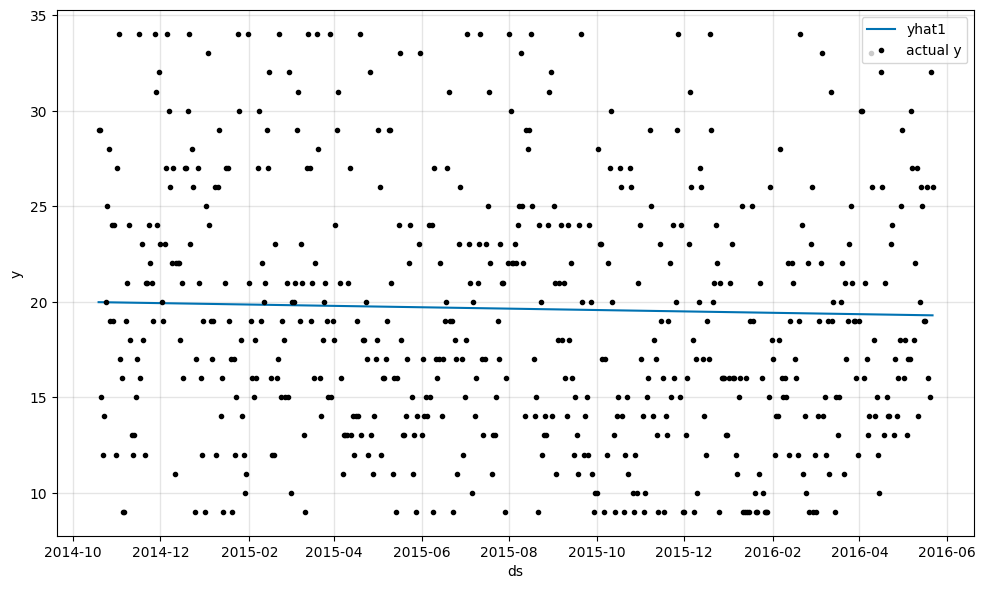

In [42]:
forecast = m.predict(df_test)
# m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast)

In [43]:
mape = mean_absolute_percentage_error(forecast.y,forecast.yhat1).round(2)
mape

0.34

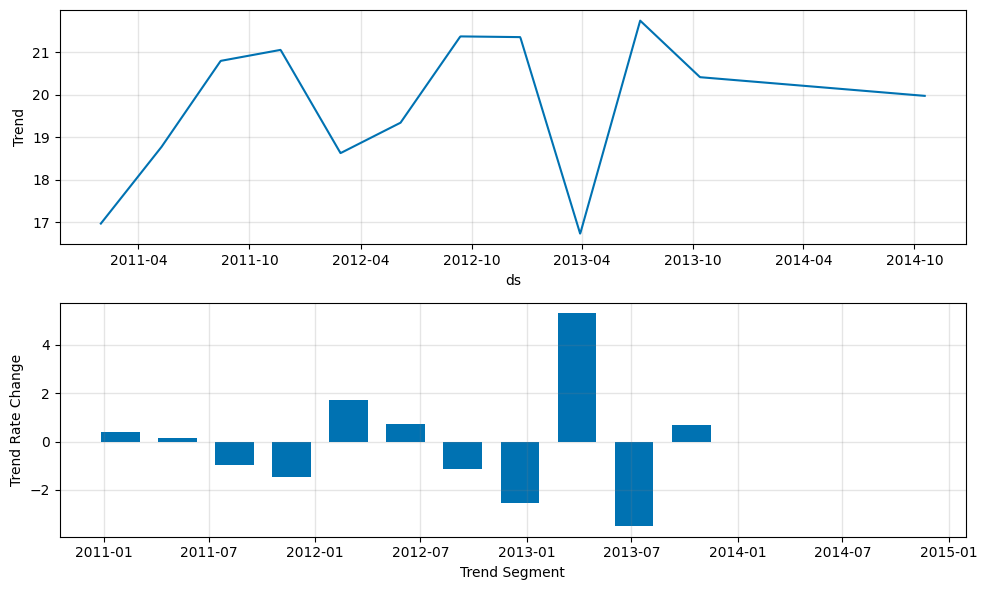

In [44]:
fig_param = m.plot_parameters()

In [45]:
m = NeuralProphet()
# df = df_item1
m.add_events(lst_CA_events)
df = m.create_df_with_events(df_item2, df_CA_events)
df_train, df_test = m.split_df(df=df, freq="D", valid_p=0.3 )
metrics = m.fit(df=df_train, freq="D" , validation_df=df_test)
metrics.tail(1)

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.948% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.926% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 176

Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=229` reached.
Restoring states from the checkpoint path at C:\Users\apugacheva\PycharmProjects\m5\.lr_find_d7b41d00-79c6-4e3a-91e6-802f638f5cc1.ckpt
Loading `train_dataloader` to estimate number of stepping batches.

  | Name          | Type             | Params
---------------------------------------------------
0 | metrics_train | MetricCollection | 0     
1 | metrics_val   | MetricCollection | 0     
2 | season_params | ParameterDict    | 18    
3 | event_params  | ParameterDict    | 31    
---------------------------------------------------
62        Trainable params
0         Non-trainable params
62        Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=176` reached.


MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch       MAE      RMSE  \
175  4.277655   5.28435  0.022339          0.0    175  4.095674  5.079086   

         Loss  RegLoss  
175  0.015663      0.0

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 43it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


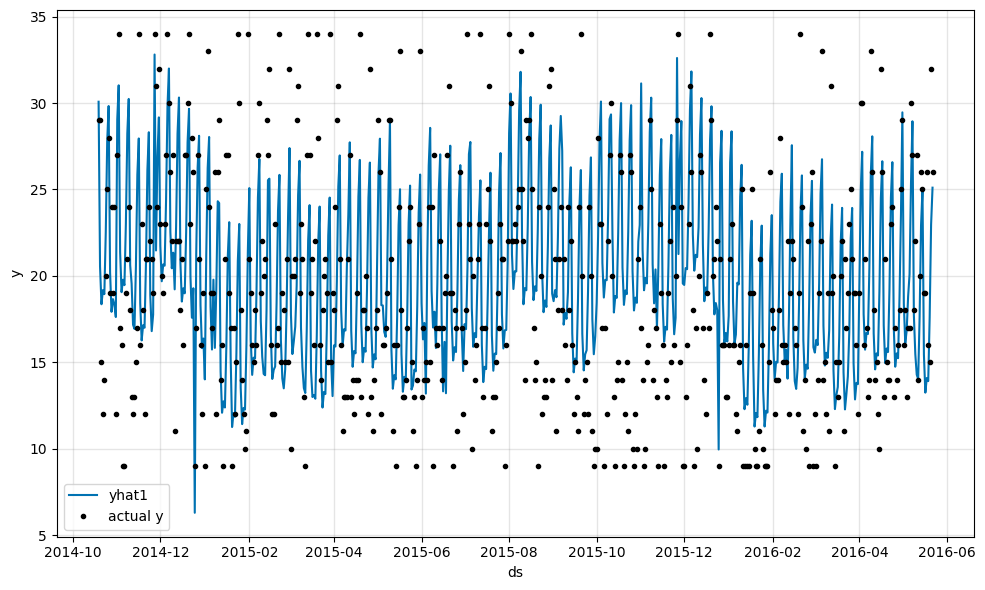

In [46]:
forecast = m.predict(df_test)
# m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast)

In [47]:
mape = mean_absolute_percentage_error(forecast.y,forecast.yhat1).round(2)
mape

0.26

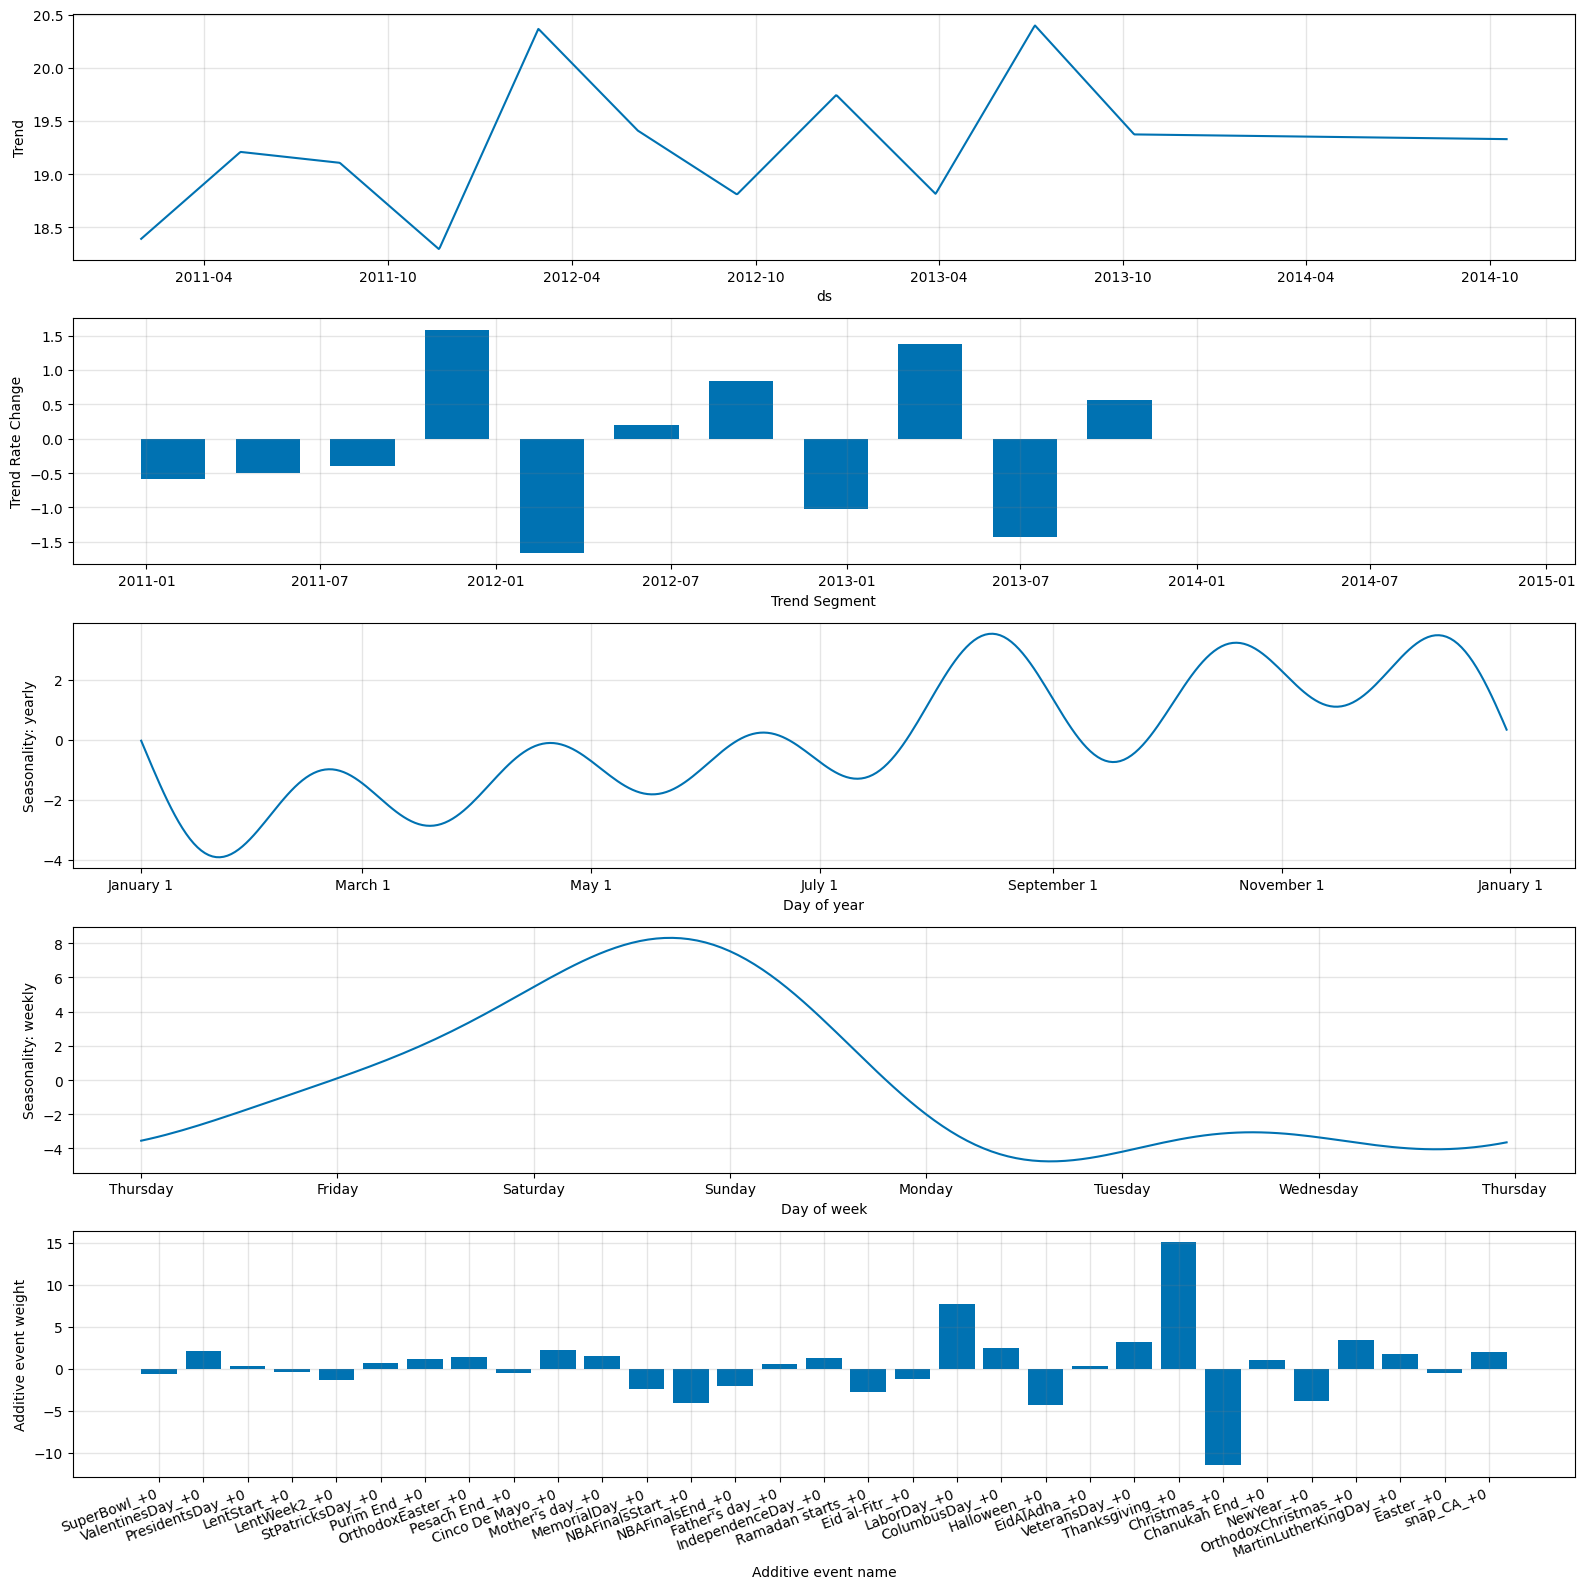

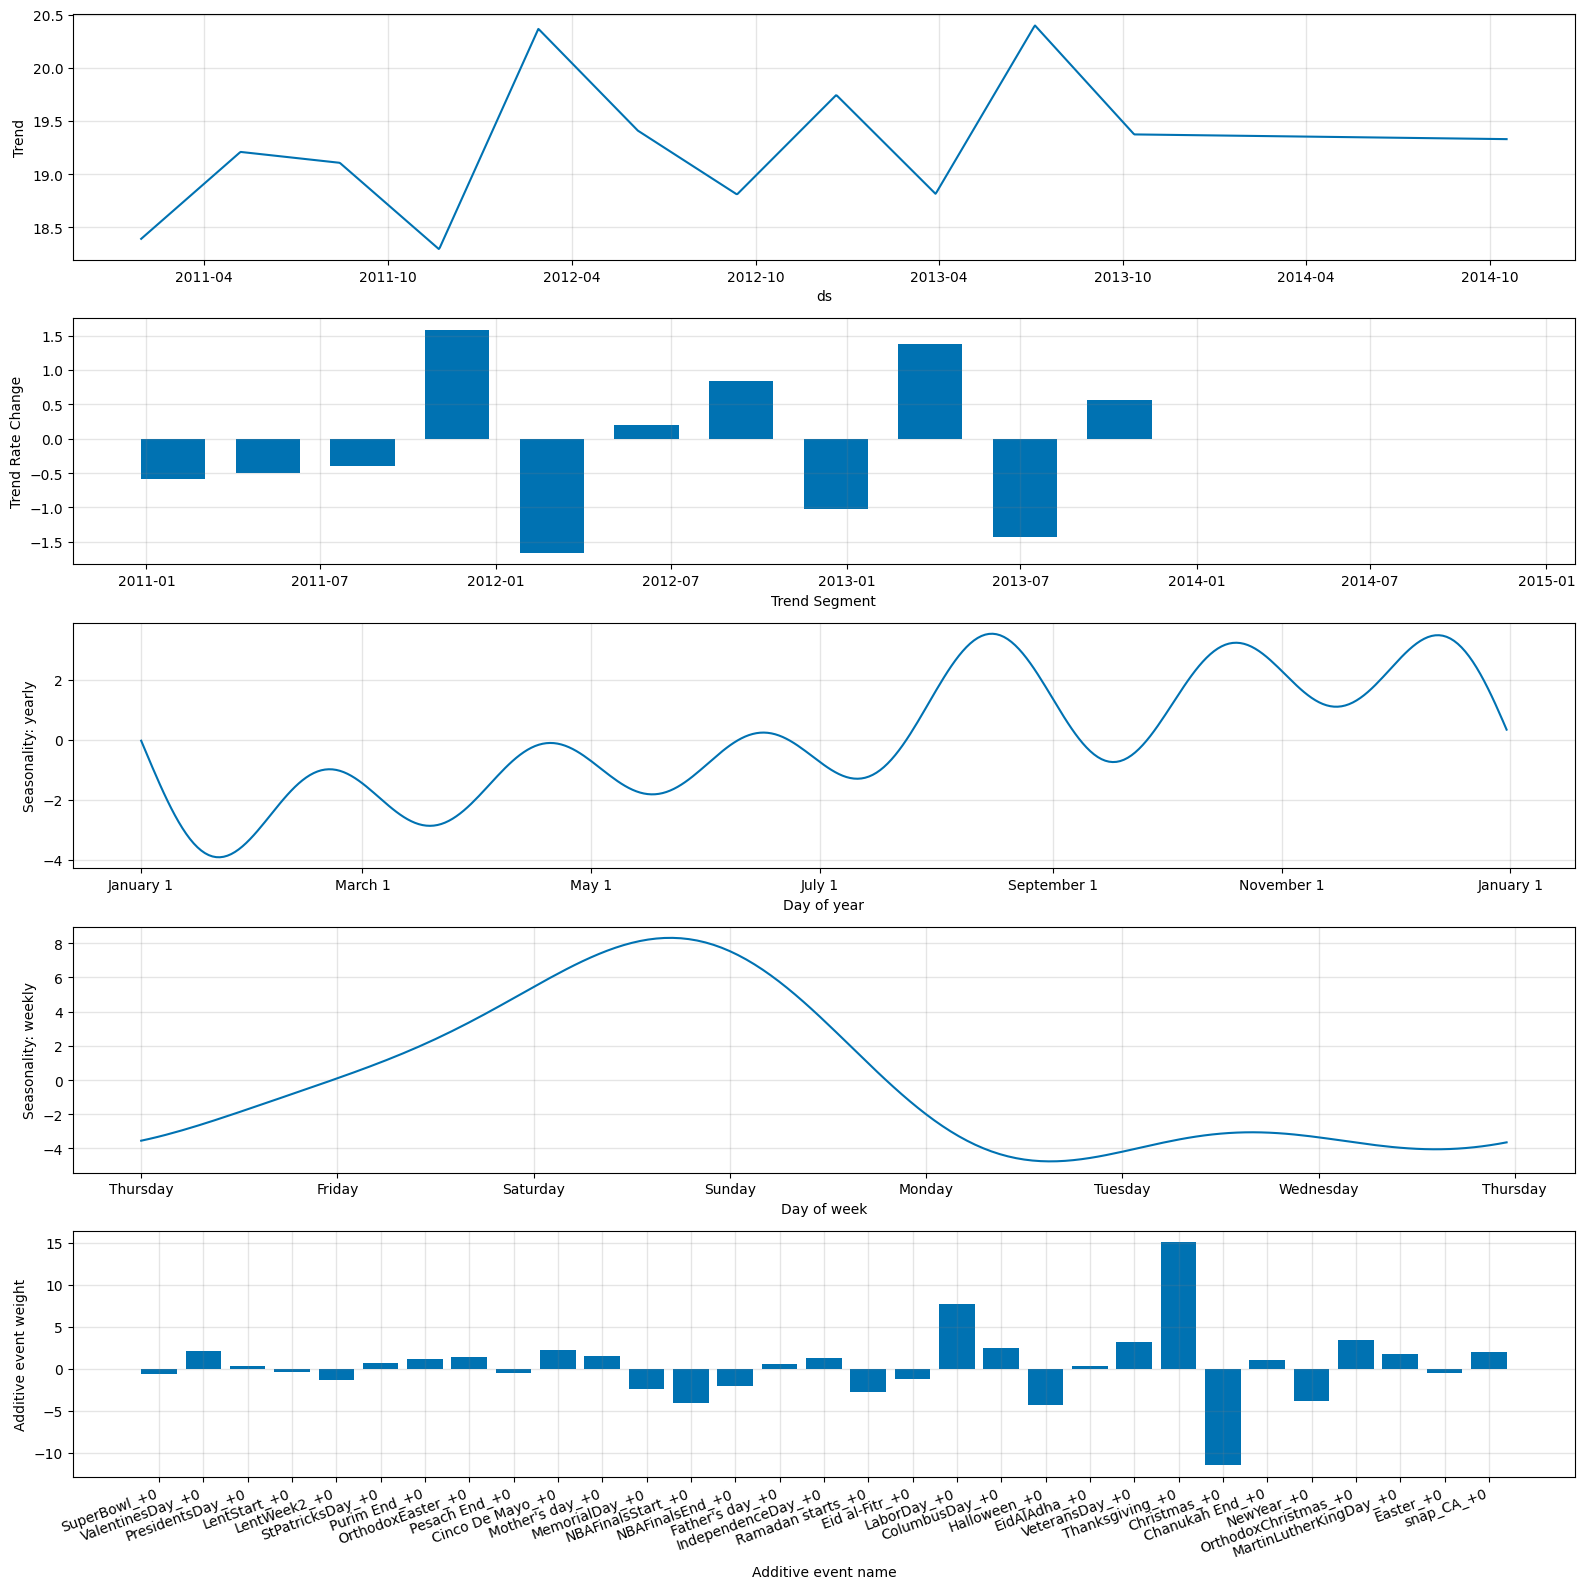

In [48]:
m.plot_parameters(figsize=(16, 16),weekly_start=4)

In [49]:
m.config_normalization

Normalization(normalize='auto', global_normalization=True, global_time_normalization=True, unknown_data_normalization=False, local_data_params=OrderedDict([('__df__', OrderedDict([('ds', ShiftScale(shift=Timestamp('2011-01-29 00:00:00'), scale=Timedelta('1358 days 00:00:00'))), ('y', ShiftScale(shift=9, scale=25.0)), ('SuperBowl', ShiftScale(shift=0.0, scale=1.0)), ('ValentinesDay', ShiftScale(shift=0.0, scale=1.0)), ('PresidentsDay', ShiftScale(shift=0.0, scale=1.0)), ('LentStart', ShiftScale(shift=0.0, scale=1.0)), ('LentWeek2', ShiftScale(shift=0.0, scale=1.0)), ('StPatricksDay', ShiftScale(shift=0.0, scale=1.0)), ('Purim End', ShiftScale(shift=0.0, scale=1.0)), ('OrthodoxEaster', ShiftScale(shift=0.0, scale=1.0)), ('Pesach End', ShiftScale(shift=0.0, scale=1.0)), ('Cinco De Mayo', ShiftScale(shift=0.0, scale=1.0)), ("Mother's day", ShiftScale(shift=0.0, scale=1.0)), ('MemorialDay', ShiftScale(shift=0.0, scale=1.0)), ('NBAFinalsStart', ShiftScale(shift=0.0, scale=1.0)), ('NBAFinalsE

In [50]:
m.config_trend

Trend(growth='linear', changepoints=array([0.        , 0.07272727, 0.14545455, 0.21818182, 0.29090909,
       0.36363636, 0.43636364, 0.50909091, 0.58181818, 0.65454545,
       0.72727273]), n_changepoints=10, changepoints_range=0.8, trend_reg=0, trend_reg_threshold=None, trend_global_local='global')

In [51]:
m.config_season

AllSeason(mode='additive', computation='fourier', reg_lambda=0, yearly_arg='auto', weekly_arg='auto', daily_arg='auto', periods=OrderedDict([('yearly', Season(resolution=6, period=365.25, arg='auto')), ('weekly', Season(resolution=3, period=7, arg='auto'))]), global_local='global')

In [52]:
param_grid_1 = {  
#     'ar_reg' : [1],
    'changepoints_range':[0.6,0.65,0.7,0.75,0.9,0.95,0.99],
    'trend_reg' : [1],
#     'growth' : ['off', 'linear'],
    'seasonality_mode' :['additive','multiplicative'],
#     'num_hidden_layers': [0,1,2]
}

# Generate all combinations of parameters
all_params_1 = [dict(zip(param_grid_1.keys(), v)) for v in itertools.product(*param_grid_1.values())]
len(all_params_1)

14

In [58]:
results_2, df_forecasted_data_2, dic_models = run_NeuralProphet_with_hyperparams(all_params_1,
                                                                               df_item2,
                                                                               df_CA_events,
                                                                               lst_CA_events)

NameError: name 'run_NeuralProphet_with_hyperparams' is not defined

In [54]:
results_2

NameError: name 'results_2' is not defined

In [55]:
int_RMSE_ModelNo = results_2.loc[(results_2.RMSE <= results_2.RMSE.min())].model_No.min()
int_MAPE_ModelNo = results_2.loc[(results_2.MAPE <= results_2.MAPE.min())].model_No.min()
results_2.loc[results_2.model_No.isin([int_RMSE_ModelNo,int_MAPE_ModelNo])]

NameError: name 'results_2' is not defined

In [56]:
print( 'RMSE Best Params : ', results_2.loc[results_2.model_No == int_RMSE_ModelNo].params.to_list())
print( 'MAPE Best Params : ', results_2.loc[results_2.model_No == int_MAPE_ModelNo].params.to_list())

NameError: name 'results_2' is not defined

In [57]:
RMSE_Model = dic_models[int_RMSE_ModelNo]
RMSE_Model.plot_parameters(figsize=(16, 16),weekly_start=4)

NameError: name 'dic_models' is not defined

In [ ]:
plot_forecast(df_forecasted_data_2.loc[(df_forecasted_data_2.model_No==int_RMSE_ModelNo)])

In [ ]:
MAPE_Model = dic_models[int_MAPE_ModelNo]
MAPE_Model.plot_parameters(figsize=(16, 16),weekly_start=4)

In [ ]:
plot_forecast(df_forecasted_data_2.loc[(df_forecasted_data_2.model_No==int_MAPE_ModelNo)])

### FOODS_3_714_TX_3_evaluation

In [ ]:
# df_item3 = df_sales.loc[(df_sales.id == 'FOODS_3_714_TX_3_evaluation')].sort_values(by=['date'], ascending=True)
# df_item3.drop(['id'], axis=1, inplace = True)
# df_item3.rename(columns = {'date':'ds', "sales":"y"}, inplace = True)

df_item3, df_TX_events, lst_TX_events = get_Product_data('FOODS_3_714_TX_3_evaluation','TX')

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_item3.ds, y=df_item3.y, name = 'FOODS_3_714_TX_3_evaluation'))
fig.update_layout(xaxis_title="Time", yaxis_title="Sales",title="",title_x=0.5)
fig.show()

In [ ]:
m = NeuralProphet(yearly_seasonality=False,
    weekly_seasonality= False,
    daily_seasonality=False,)
df = df_item3
df_train, df_test = m.split_df(df=df, freq="D", valid_p=0.3 )
metrics = m.fit(df=df_train, freq="D" , validation_df=df_test)
metrics.tail(1)

In [ ]:
forecast = m.predict(df_test)
# m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast)

In [ ]:
mape = mean_absolute_percentage_error(forecast.y,forecast.yhat1).round(2)
mape

In [ ]:
fig_param = m.plot_parameters(weekly_start=4)

In [ ]:
m = NeuralProphet()
m.add_events(lst_TX_events)
df = m.create_df_with_events(df_item3, df_TX_events)
df_train, df_test = m.split_df(df=df, freq="D", valid_p=0.3 )
metrics = m.fit(df=df_train, freq="D" , validation_df=df_test)
metrics.tail(1)

In [ ]:
forecast = m.predict(df_test)
# m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast,figsize=(12, 6))

In [ ]:
mape = mean_absolute_percentage_error(forecast.y,forecast.yhat1).round(2)
mape

In [ ]:
fig_param = m.plot_parameters(figsize=(16, 16),weekly_start=4)

In [ ]:
param_grid_1 = {  
#     'ar_reg' : [1],
    'changepoints_range':[0.6,0.65,0.7,0.75,0.9,0.95,0.99],
#     'trend_reg' : [1],
#     'growth' : ['off', 'linear'],
    'seasonality_mode' :['additive','multiplicative'],
#     'num_hidden_layers': [0,1,2]
}

# Generate all combinations of parameters
all_params_1 = [dict(zip(param_grid_1.keys(), v)) for v in itertools.product(*param_grid_1.values())]
len(all_params_1)

In [ ]:
results_3, df_forecasted_data_3, dic_models = run_NeuralProphet_with_hyperparams(all_params_1,
                                                                               df_item3,
                                                                               df_TX_events,
                                                                               lst_TX_events)

In [ ]:
results_3

In [ ]:
int_RMSE_ModelNo = results_3.loc[(results_3.RMSE <= results_3.RMSE.min())].model_No.min()
int_MAPE_ModelNo = results_3.loc[(results_3.MAPE <= results_3.MAPE.min())].model_No.min()
results_3.loc[results_3.model_No.isin([int_RMSE_ModelNo,int_MAPE_ModelNo])]

In [ ]:
print( 'RMSE Best Params : ', results_3.loc[results_3.model_No == int_RMSE_ModelNo].params.to_list())
print( 'MAPE Best Params : ', results_3.loc[results_3.model_No == int_MAPE_ModelNo].params.to_list())

In [ ]:
RMSE_Model = dic_models[int_RMSE_ModelNo]
RMSE_Model.plot_parameters(figsize=(16, 16),weekly_start=4)

In [ ]:
plot_forecast(df_forecasted_data_3.loc[(df_forecasted_data_3.model_No==int_RMSE_ModelNo)])

In [ ]:
MAPE_Model = dic_models[int_MAPE_ModelNo]
MAPE_Model.plot_parameters(figsize=(16, 16),weekly_start=4)

In [ ]:
plot_forecast(df_forecasted_data_3.loc[(df_forecasted_data_3.model_No==int_MAPE_ModelNo)])

### FOODS_3_586_WI_1_evaluation

In [ ]:
df_item4, df_WI_events, lst_WI_events = get_Product_data('FOODS_3_586_WI_1_evaluation','WI')

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_item4.ds, y=df_item4.y, name = 'FOODS_3_586_WI_1_evaluation'))
fig.update_layout(xaxis_title="Time", yaxis_title="Sales",title="",title_x=0.5)
fig.show()

In [ ]:
m = NeuralProphet(yearly_seasonality=False,
    weekly_seasonality= False,
    daily_seasonality=False,)
df = df_item4
df_train, df_test = m.split_df(df=df, freq="D", valid_p=0.3 )
metrics = m.fit(df=df_train, freq="D" , validation_df=df_test)
metrics.tail(1)

In [ ]:
forecast = m.predict(df_test)
# m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast)

In [ ]:
mape = mean_absolute_percentage_error(forecast.y,forecast.yhat1).round(2)
mape

In [ ]:
fig_param = m.plot_parameters(weekly_start=4)

In [ ]:
m = NeuralProphet()
m.add_events(lst_WI_events)
df = m.create_df_with_events(df_item4, df_WI_events)
df_train, df_test = m.split_df(df=df, freq="D", valid_p=0.3 )
metrics = m.fit(df=df_train, freq="D" , validation_df=df_test)
metrics.tail(1)

In [ ]:
forecast = m.predict(df_test)
# m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast,figsize=(12, 6))

In [ ]:
mape = mean_absolute_percentage_error(forecast.y,forecast.yhat1).round(2)
mape

In [ ]:
fig_param = m.plot_parameters(figsize=(16, 16),weekly_start=4)

In [ ]:
param_grid_1 = {  
#     'ar_reg' : [1],
    'changepoints_range':[0.6,0.65,0.7,0.75,0.9,0.95,0.99],
#     'trend_reg' : [1],
    'growth' : ['off', 'linear'],
    'seasonality_mode' :['additive','multiplicative'],
#     'num_hidden_layers': [0,1,2]
}

# Generate all combinations of parameters
all_params_1 = [dict(zip(param_grid_1.keys(), v)) for v in itertools.product(*param_grid_1.values())]
len(all_params_1)

In [ ]:
results_4, df_forecasted_data_4, dic_models = run_NeuralProphet_with_hyperparams(all_params_1,
                                                                               df_item4,
                                                                               df_WI_events,
                                                                               lst_WI_events)

In [ ]:
results_4

In [ ]:
int_RMSE_ModelNo = results_4.loc[(results_4.RMSE <= results_4.RMSE.min())].model_No.min()
int_MAPE_ModelNo = results_4.loc[(results_4.MAPE <= results_4.MAPE.min())].model_No.min()
results_4.loc[results_4.model_No.isin([int_RMSE_ModelNo,int_MAPE_ModelNo])]

In [ ]:
print( 'RMSE Best Params : ', results_4.loc[results_4.model_No == int_RMSE_ModelNo].params.to_list())
print( 'MAPE Best Params : ', results_4.loc[results_4.model_No == int_MAPE_ModelNo].params.to_list())

In [ ]:
RMSE_Model = dic_models[int_RMSE_ModelNo]
RMSE_Model.plot_parameters(figsize=(16, 16),weekly_start=4)

In [ ]:
plot_forecast(df_forecasted_data_4.loc[(df_forecasted_data_4.model_No==int_RMSE_ModelNo)])

In [ ]:
MAPE_Model = dic_models[int_MAPE_ModelNo]
MAPE_Model.plot_parameters(figsize=(16, 16),weekly_start=4)

In [ ]:
plot_forecast(df_forecasted_data_4.loc[(df_forecasted_data_4.model_No==int_MAPE_ModelNo)])

### FOODS_3_252_TX_1_evaluation

In [ ]:
df_item5, df_TX_events, lst_TX_events = get_Product_data('FOODS_3_252_TX_1_evaluation','TX')

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_item5.ds, y=df_item5.y, name = 'FOODS_3_252_TX_1_evaluation'))
fig.update_layout(xaxis_title="Time", yaxis_title="Sales",title="",title_x=0.5)
fig.show()

In [ ]:
m = NeuralProphet(yearly_seasonality=False,
    weekly_seasonality= False,
    daily_seasonality=False,)
df = df_item5
df_train, df_test = m.split_df(df=df, freq="D", valid_p=0.3 )
metrics = m.fit(df=df_train, freq="D" , validation_df=df_test)
metrics.tail(1)

In [ ]:
forecast = m.predict(df_test)
# m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast)

In [ ]:
mape = mean_absolute_percentage_error(forecast.y,forecast.yhat1).round(2)
mape

In [ ]:
fig_param = m.plot_parameters(weekly_start=4)

In [ ]:
m = NeuralProphet()
m.add_events(lst_TX_events)
df = m.create_df_with_events(df_item5, df_TX_events)
df_train, df_test = m.split_df(df=df, freq="D", valid_p=0.3 )
metrics = m.fit(df=df_train, freq="D" , validation_df=df_test)
metrics.tail(1)

In [ ]:
forecast = m.predict(df_test)
# m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast,figsize=(12, 6))

In [ ]:
mape = mean_absolute_percentage_error(forecast.y,forecast.yhat1).round(2)
mape

In [ ]:
fig_param = m.plot_parameters(figsize=(16, 16),weekly_start=4)

In [ ]:
param_grid_1 = {  
#     'ar_reg' : [1],
    'changepoints_range':[0.6,0.65,0.7,0.75,0.9,0.95,0.99],
#     'trend_reg' : [1],
    'growth' : ['off', 'linear'],
    'seasonality_mode' :['additive','multiplicative'],
    'num_hidden_layers': [0,1,2]
}

# Generate all combinations of parameters
all_params_1 = [dict(zip(param_grid_1.keys(), v)) for v in itertools.product(*param_grid_1.values())]
len(all_params_1)

In [ ]:
results_5, df_forecasted_data_5, dic_models = run_NeuralProphet_with_hyperparams(all_params_1,
                                                                               df_item5,
                                                                               df_TX_events,
                                                                               lst_TX_events)

In [ ]:
results_5

In [ ]:
int_RMSE_ModelNo = results_5.loc[(results_5.RMSE <= results_5.RMSE.min())].model_No.min()
int_MAPE_ModelNo = results_5.loc[(results_5.MAPE <= results_5.MAPE.min())].model_No.min()
results_5.loc[results_5.model_No.isin([int_RMSE_ModelNo,int_MAPE_ModelNo])]

In [ ]:
print( 'RMSE Best Params : ', results_5.loc[results_5.model_No == int_RMSE_ModelNo].params.to_list())
print( 'MAPE Best Params : ', results_5.loc[results_5.model_No == int_MAPE_ModelNo].params.to_list())

In [ ]:
RMSE_Model = dic_models[int_RMSE_ModelNo]
RMSE_Model.plot_parameters(figsize=(16, 16),weekly_start=4)

In [ ]:
plot_forecast(df_forecasted_data_5.loc[(df_forecasted_data_5.model_No==int_RMSE_ModelNo)])

In [ ]:
MAPE_Model = dic_models[int_MAPE_ModelNo]
MAPE_Model.plot_parameters(figsize=(16, 16),weekly_start=4)

In [ ]:
plot_forecast(df_forecasted_data_5.loc[(df_forecasted_data_5.model_No==int_MAPE_ModelNo)])

### FOODS_3_714_TX_2_evaluation

In [ ]:
df_item6, df_TX_events, lst_TX_events = get_Product_data('FOODS_3_714_TX_2_evaluation','TX')

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_item6.ds, y=df_item6.y, name = 'FOODS_3_714_TX_2_evaluation'))
fig.update_layout(xaxis_title="Time", yaxis_title="Sales",title="",title_x=0.5)
fig.show()

In [ ]:
m = NeuralProphet(yearly_seasonality=False,
    weekly_seasonality= False,
    daily_seasonality=False,)
df = df_item6
df_train, df_test = m.split_df(df=df, freq="D", valid_p=0.3 )
metrics = m.fit(df=df_train, freq="D" , validation_df=df_test)
metrics.tail(1)

In [ ]:
forecast = m.predict(df_test)
# m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast)

In [ ]:
mape = mean_absolute_percentage_error(forecast.y,forecast.yhat1).round(2)
mape

In [ ]:
fig_param = m.plot_parameters(weekly_start=4)

In [ ]:
m = NeuralProphet()
m.add_events(lst_TX_events)
df = m.create_df_with_events(df_item6, df_TX_events)
df_train, df_test = m.split_df(df=df, freq="D", valid_p=0.3 )
metrics = m.fit(df=df_train, freq="D" , validation_df=df_test)
metrics.tail(1)

In [ ]:
forecast = m.predict(df_test)
# m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast,figsize=(12, 6))

In [ ]:
mape = mean_absolute_percentage_error(forecast.y,forecast.yhat1).round(2)
mape

In [ ]:
fig_param = m.plot_parameters(figsize=(16, 16),weekly_start=4)

In [ ]:
param_grid_1 = {  
#     'ar_reg' : [1],
    'changepoints_range':[0.6,0.65,0.7,0.75,0.9,0.95,0.99],
#     'trend_reg' : [1],
    'growth' : ['off', 'linear'],
    'seasonality_mode' :['additive','multiplicative'],
    'num_hidden_layers': [0,1,2]
}

# Generate all combinations of parameters
all_params_1 = [dict(zip(param_grid_1.keys(), v)) for v in itertools.product(*param_grid_1.values())]
len(all_params_1)

In [ ]:
results_6, df_forecasted_data_6, dic_models = run_NeuralProphet_with_hyperparams(all_params_1,
                                                                               df_item6,
                                                                               df_TX_events,
                                                                               lst_TX_events)

In [ ]:
results_6

In [ ]:
int_RMSE_ModelNo = results_6.loc[(results_6.RMSE <= results_6.RMSE.min())].model_No.min()
int_MAPE_ModelNo = results_6.loc[(results_6.MAPE <= results_6.MAPE.min())].model_No.min()
results_6.loc[results_6.model_No.isin([int_RMSE_ModelNo,int_MAPE_ModelNo])]

In [ ]:
print( 'RMSE Best Params : ', results_6.loc[results_6.model_No == int_RMSE_ModelNo].params.to_list())
print( 'MAPE Best Params : ', results_6.loc[results_6.model_No == int_MAPE_ModelNo].params.to_list())

In [ ]:
RMSE_Model = dic_models[int_RMSE_ModelNo]
RMSE_Model.plot_parameters(figsize=(16, 16),weekly_start=4)

In [ ]:
plot_forecast(df_forecasted_data_6.loc[(df_forecasted_data_6.model_No==int_RMSE_ModelNo)])

In [ ]:
MAPE_Model = dic_models[int_MAPE_ModelNo]
MAPE_Model.plot_parameters(figsize=(16, 16),weekly_start=4)

In [ ]:
plot_forecast(df_forecasted_data_6.loc[(df_forecasted_data_5.model_No==int_MAPE_ModelNo)])